# Business Case: LoanTap Logistic Regression

LoanTap is an online platform committed to delivering customized loan products to millennials. They innovate in an otherwise dull loan segment, to deliver instant, flexible loans on consumer friendly terms to salaried professionals and businessmen.

The data science team at LoanTap is building an underwriting layer to determine the creditworthiness of MSMEs as well as individuals.

LoanTap deploys formal credit to salaried individuals and businesses 4 main financial instruments:

Personal Loan
EMI Free Loan
Personal Overdraft
Advance Salary Loan
This case study will focus on the underwriting process behind Personal Loan only

1. Personal Loan
2. EMI Free Loan
3. Personal Overdraft
4. Advance Salary Loan

This case study will focus on the underwriting process behind Personal Loan only

## Problem Statement:

Given a set of attributes for an Individual, determine if a credit line should be extended to them. If so, what should the repayment terms be in business recommendations?

In [624]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats 
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, auc,
    ConfusionMatrixDisplay, RocCurveDisplay
)
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE

In [625]:
data = pd.read_csv('loantap.txt')

In [626]:
data.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,Not Verified,Jan-2015,Fully Paid,vacation,Vacation,26.24,Jun-1990,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,Not Verified,Jan-2015,Fully Paid,debt_consolidation,Debt consolidation,22.05,Jul-2004,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,Source Verified,Jan-2015,Fully Paid,credit_card,Credit card refinancing,12.79,Aug-2007,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,Not Verified,Nov-2014,Fully Paid,credit_card,Credit card refinancing,2.60,Sep-2006,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,Verified,Apr-2013,Charged Off,credit_card,Credit Card Refinance,33.95,Mar-1999,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\nGreggshire, VA 11650"


In [627]:
data.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose', 'title',
       'dti', 'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'application_type',
       'mort_acc', 'pub_rec_bankruptcies', 'address'],
      dtype='object')

In [628]:
#Shape of the dataset
print(f'No. of rows: {data.shape[0]}')
print(f'No. of columns: {data.shape[1]}')

No. of rows: 41364
No. of columns: 27


In [629]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41364 entries, 0 to 41363
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   loan_amnt             41364 non-null  float64
 1   term                  41364 non-null  object 
 2   int_rate              41364 non-null  float64
 3   installment           41364 non-null  float64
 4   grade                 41364 non-null  object 
 5   sub_grade             41364 non-null  object 
 6   emp_title             39000 non-null  object 
 7   emp_length            39464 non-null  object 
 8   home_ownership        41364 non-null  object 
 9   annual_inc            41364 non-null  float64
 10  verification_status   41364 non-null  object 
 11  issue_d               41364 non-null  object 
 12  loan_status           41364 non-null  object 
 13  purpose               41364 non-null  object 
 14  title                 41198 non-null  object 
 15  dti                

In [630]:
data.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
loan_amnt,41364.0,NaN,NaN,NaN,14120.26158,8378.472648,500.0,8000.0,12000.0,20000.0,40000.0
term,41364,2,36 months,31545,NaN,NaN,NaN,NaN,NaN,NaN,NaN
int_rate,41364.0,NaN,NaN,NaN,13.651636,4.462072,5.32,10.49,13.33,16.55,30.74
installment,41364.0,NaN,NaN,NaN,431.998578,250.823082,16.31,250.94,376.19,566.585,1533.81
grade,41364,7,B,12188,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub_grade,41364,35,B3,2817,NaN,NaN,NaN,NaN,NaN,NaN,NaN
emp_title,39000,24520,Manager,473,NaN,NaN,NaN,NaN,NaN,NaN,NaN
emp_length,39464,11,10+ years,13306,NaN,NaN,NaN,NaN,NaN,NaN,NaN
home_ownership,41364,6,MORTGAGE,20625,NaN,NaN,NaN,NaN,NaN,NaN,NaN
annual_inc,41364.0,NaN,NaN,NaN,74282.023504,59470.003858,2500.0,45000.0,64000.0,90000.0,6100000.0


In [631]:
#Checking Null values in our dataset
data.isna().sum()

loan_amnt                  0
term                       0
int_rate                   0
installment                0
grade                      0
sub_grade                  0
emp_title               2364
emp_length              1900
home_ownership             0
annual_inc                 0
verification_status        0
issue_d                    0
loan_status                0
purpose                    0
title                    166
dti                        0
earliest_cr_line           0
open_acc                   0
pub_rec                    0
revol_bal                  0
revol_util                27
total_acc                  0
initial_list_status        0
application_type           0
mort_acc                3825
pub_rec_bankruptcies      54
address                    1
dtype: int64

In [632]:
#checking for unique values in our dataset
data.nunique()

loan_amnt                1222
term                        2
int_rate                  470
installment             17240
grade                       7
sub_grade                  35
emp_title               24520
emp_length                 11
home_ownership              6
annual_inc               4601
verification_status         3
issue_d                   115
loan_status                 2
purpose                    14
title                    6995
dti                      3846
earliest_cr_line          583
open_acc                   50
pub_rec                    12
revol_bal               23799
revol_util               1052
total_acc                  96
initial_list_status         2
application_type            3
mort_acc                   23
pub_rec_bankruptcies        7
address                 41332
dtype: int64

In [633]:
#checking for duplicate values in our dataset
data.duplicated().sum()

0

## Observations
1. From the dataset we can see that there are 41364 samples and 27 features.
2. The features are either of float or object/string datatype. The object datatypes will need to be converted to int.
3. While checking the null values in the dataset, the mort_acc feature has the highest number of null values which is 3825. The 2nd highest being emp_title - 2364, followed by emp_length - 1900, title - 166, revol_util - 27 and pub_rec_bankruptcies - 54.
4. We can see that 80% of the people have fully paid the loan amount while 20% of the loan amount has been Charged off.
5. While checking for unique values in our dataset, we can see that there are no features with unique values. 
6. There are no duplicate rows in our dataset.

## Exploratory Data Analysis

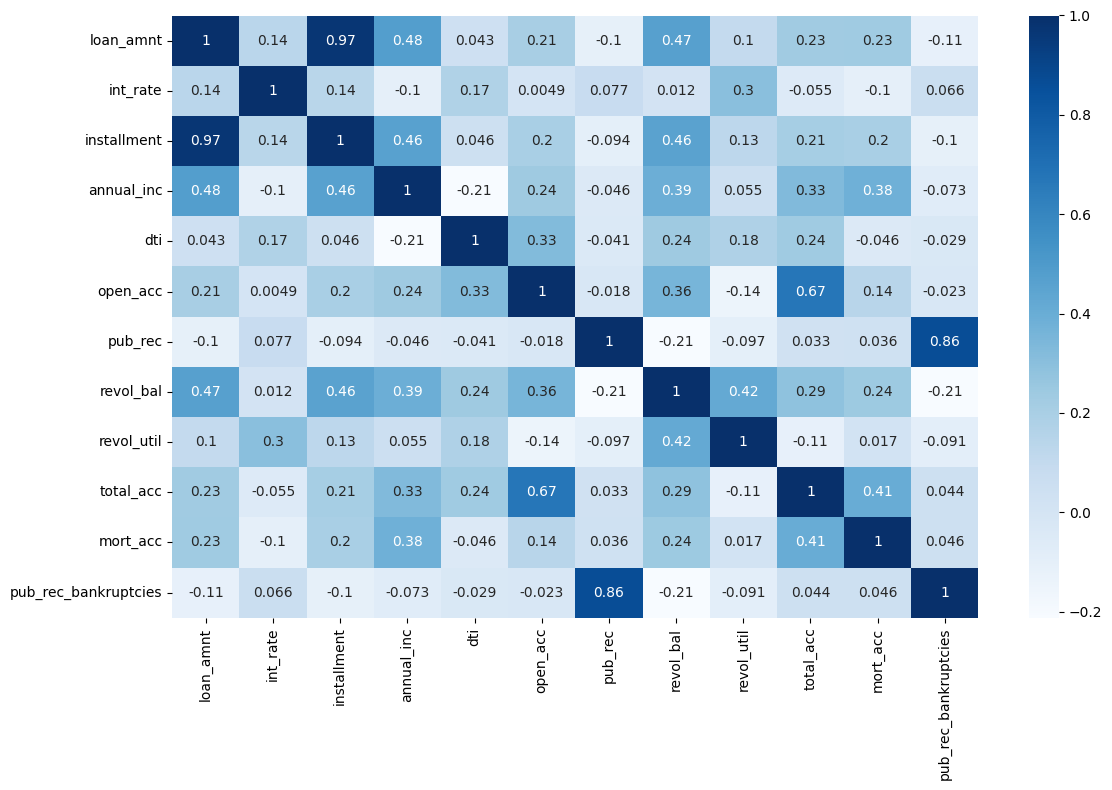

In [634]:
import warnings
warnings.filterwarnings('ignore')

plt.figure(figsize = (12,8))
sns.heatmap(data.corr(method = 'spearman'), annot = True, cmap = 'Blues')
plt.tight_layout()
plt.show()

## Observations from the heatmap:
1. We can see that the **loan_amnt** and **installment** feature have a really high positive correlation (almost perfect), so we can drop either one of these columns.

**loan_amnt** : The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.

**installment** : The monthly payment owed by the borrower if the loan originates.

2. open_acc and total_acc also has a high positive correlation.
3. pub_rec_bankruptcies and pub_rec has a high positive correlation as well

In [635]:
data.drop('installment',axis = 1, inplace = True)

## Exploratory Data Analysis

In [636]:
#Checking distribution of our target variable

data['loan_status'].value_counts(normalize = True)*100

Fully Paid     80.55072
Charged Off    19.44928
Name: loan_status, dtype: float64

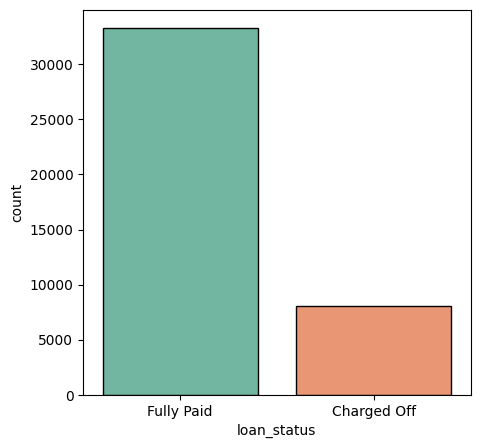

In [637]:
plt.figure(figsize = (5,5))
sns.countplot(x = data['loan_status'], palette = 'Set2', edgecolor = 'black')
plt.show()

We can see that 80% of the applicants have fully paid the loan amount whereas 20% of the loan amount is Charged Off.

In [638]:
data.groupby('loan_status')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,8045.0,15084.319453,8521.797075,1000.0,8400.0,14000.0,20000.0,40000.0
Fully Paid,33319.0,13887.486119,8326.914769,500.0,7500.0,12000.0,19287.5,40000.0


In [639]:
data['home_ownership'].value_counts()

MORTGAGE    20625
RENT        16782
OWN          3942
OTHER          13
NONE            1
ANY             1
Name: home_ownership, dtype: int64

#### Note:
We can see combine the Other + None + Any categories into 1 class because these are in minorities

In [640]:
data.loc[(df['home_ownership'] == 'ANY') | (data['home_ownership'] == 'NONE'), 'home_ownership'] = 'OTHER'  
data['home_ownership'].value_counts()

MORTGAGE    20625
RENT        16782
OWN          3942
OTHER          14
ANY             1
Name: home_ownership, dtype: int64

In [641]:
# Checking the distribution of 'Other' class vs loan_status
data.loc[df['home_ownership']=='OTHER','loan_status'].value_counts()

Fully Paid     11
Charged Off     4
Name: loan_status, dtype: int64

In [642]:
#Coverting issue_d and earliest_cr_line to date-time format

data['issue_d'] = pd.to_datetime(data['issue_d'])
data['earliest_cr_line'] = pd.to_datetime(data['earliest_cr_line'])

In [643]:
data['emp_title'].value_counts() 

Manager                                                            473
Teacher                                                            463
Supervisor                                                         198
Registered Nurse                                                   198
RN                                                                 189
Project Manager                                                    162
Driver                                                             158
Office Manager                                                     151
Sales                                                              150
Owner                                                              146
Director                                                           113
General Manager                                                    109
teacher                                                            108
Engineer                                                           104
driver

#### Note:
1. We can see that the emp_title is filled manually and has over 24k unique entries. We can select the top 20 most filled entries from the emp_title for our analysis.

In [644]:
data['emp_title'] = df['emp_title'].str.lower()

In [645]:
data['emp_title'].value_counts()[:20]

manager               588
teacher               581
supervisor            283
driver                273
registered nurse      257
owner                 227
sales                 219
rn                    210
office manager        203
project manager       188
general manager       162
truck driver          143
director              126
engineer              123
vice president        110
sales manager         104
police officer        104
operations manager    100
store manager          96
account manager        95
Name: emp_title, dtype: int64

#### Note:
We can see that emp_titles with most applications for loan are either Managers or Teachers by profession.

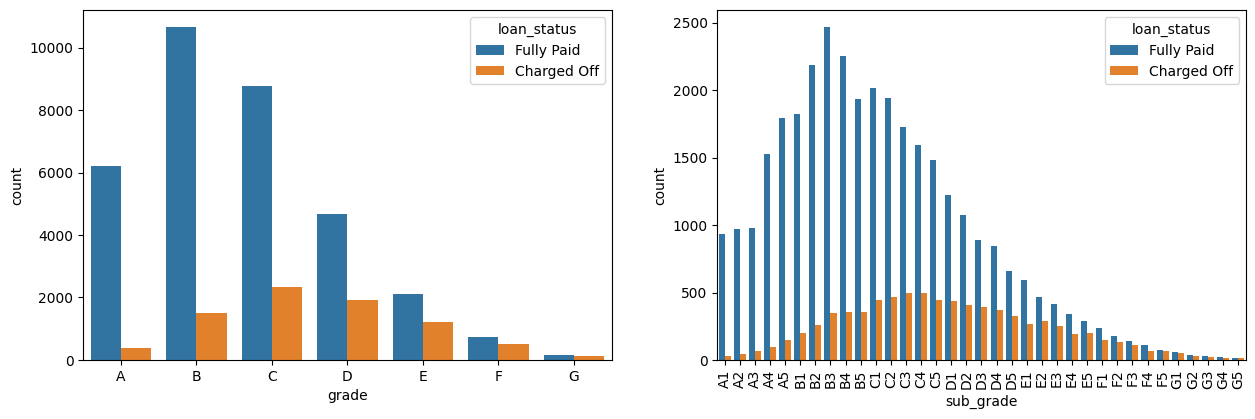

In [646]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
grade = sorted(data['grade'].unique().tolist())
sns.countplot(x='grade', data=data, hue='loan_status', order=grade)

plt.subplot(2, 2, 2)
sub_grade = sorted(df.sub_grade.unique().tolist())
g = sns.countplot(x='sub_grade', data=data, hue='loan_status', order=sub_grade)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.show()

### Observations:
1. The majority of the loan that is fully paid is by the people in B grade category. 
2. People falling in the B3 subgrade in B grade category are the highest in paying the full amount of loan. So we can infer that people with Grade B and subgrade B3 are more likely to pay the full amount of loan.
3. The highest amount of loan amount that is charged off is from the C grade category. 
4. C3 and C4 subgrades both have equal range of amount that is charged off.

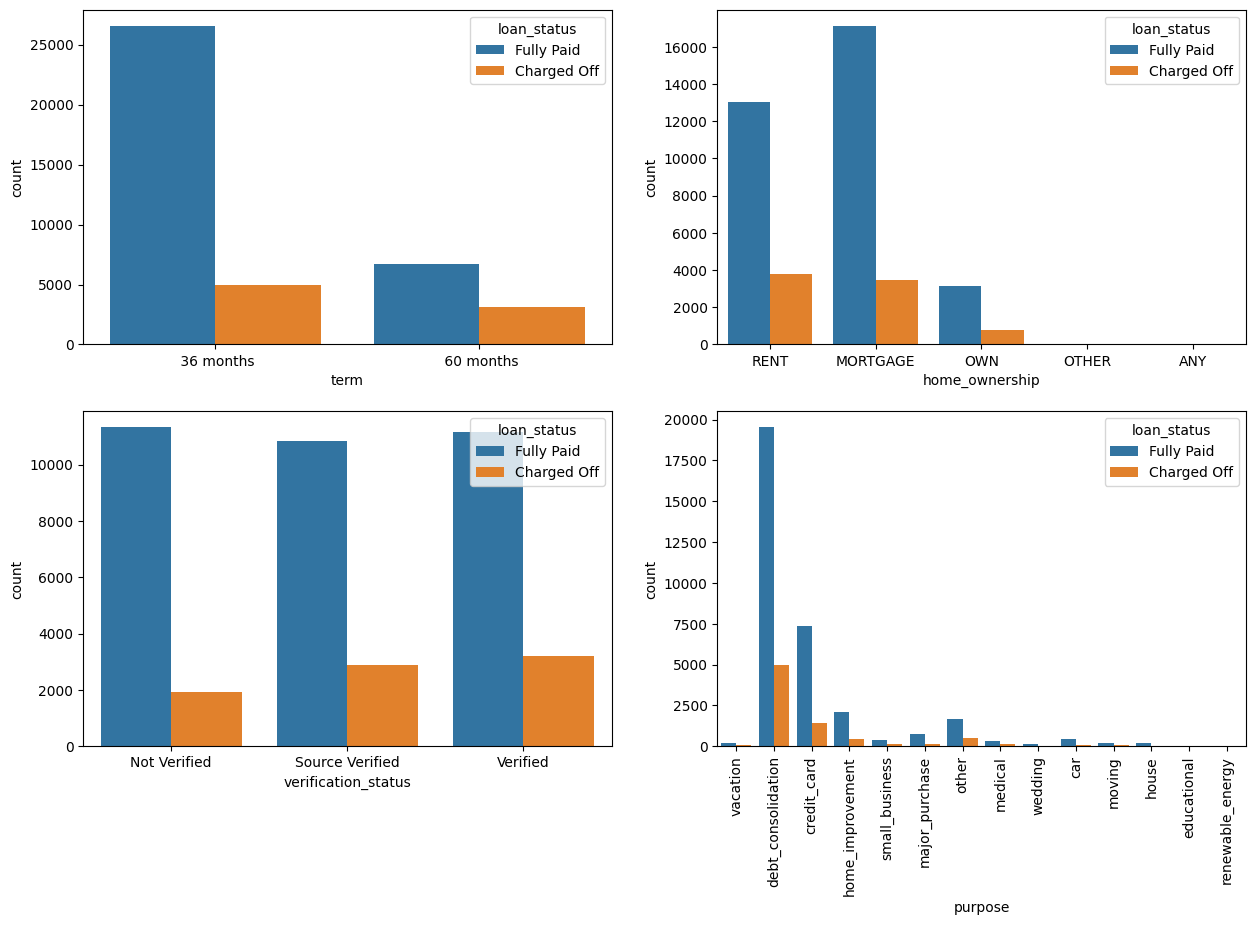

In [647]:
plt.figure(figsize=(15,20))

plt.subplot(4,2,1)
sns.countplot(x='term',data=data,hue='loan_status')

plt.subplot(4,2,2)
sns.countplot(x='home_ownership',data=data,hue='loan_status')

plt.subplot(4,2,3)
sns.countplot(x='verification_status',data=data,hue='loan_status')

plt.subplot(4,2,4)
g=sns.countplot(x='purpose',data=data,hue='loan_status')
g.set_xticklabels(g.get_xticklabels(),rotation=90)

plt.show()

### Observations:
1. Most people apply for 36 months of term as opposed to 60 months of term.
2. Most loan applications are against the mortgage and 2nd highest applications are of people living on rent.
3. From the verification status, we can't infer much because the verification_status is almost the same for all three categories.
4. From the purpose plot, we can see that the majority of the loans were applied for debt consolidation and the 2nd highest is for the credit card.

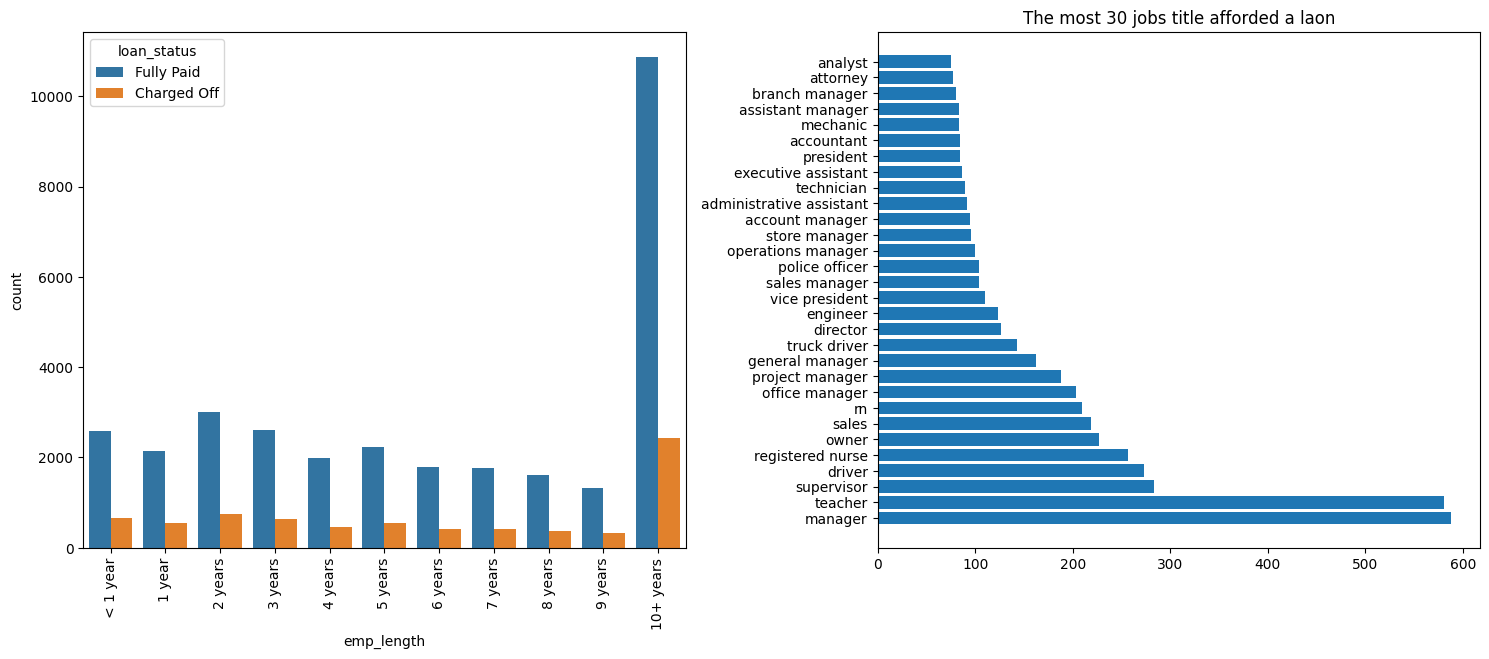

In [648]:
plt.figure(figsize=(15,12))

plt.subplot(2,2,1)
order = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', 
          '6 years', '7 years', '8 years', '9 years', '10+ years',]
g=sns.countplot(x='emp_length',data=data,hue='loan_status',order=order)
g.set_xticklabels(g.get_xticklabels(),rotation=90)

plt.subplot(2,2,2)
plt.barh(data.emp_title.value_counts()[:30].index,data.emp_title.value_counts()[:30])
plt.title("The most 30 jobs title afforded a laon")
plt.tight_layout()

### Observations:
1. The applicants with more than 10+ years of employement length are more likely to pay back the full amount of loan. They are also the people who have applied the most for the loans.
2. We can see that emp_titles with most applications for loan are either Managers or Teachers by profession.

## Feature Engineering

In [649]:
#below are high outlier columns. We dont want to delete these records since someone whos taken a loan for the first time may have low bankruptucy record
#so im just flagging anything more than 0 as 1

def pub_rec(number):
    if number == 0.0:
        return 0
    else:
        return 1
    
def mort_acc(number):
    if number == 0.0:
        return 0
    elif number >= 1.0:
        return 1
    else:
        return number
    
    
def pub_rec_bankruptcies(number):
    if number == 0.0:
        return 0
    elif number >= 1.0:
        return 1
    else:
        return number

In [650]:
data['pub_rec']=data.pub_rec.apply(pub_rec)
data['mort_acc']=data.mort_acc.apply(mort_acc)
data['pub_rec_bankruptcies']=data.pub_rec_bankruptcies.apply(pub_rec_bankruptcies)

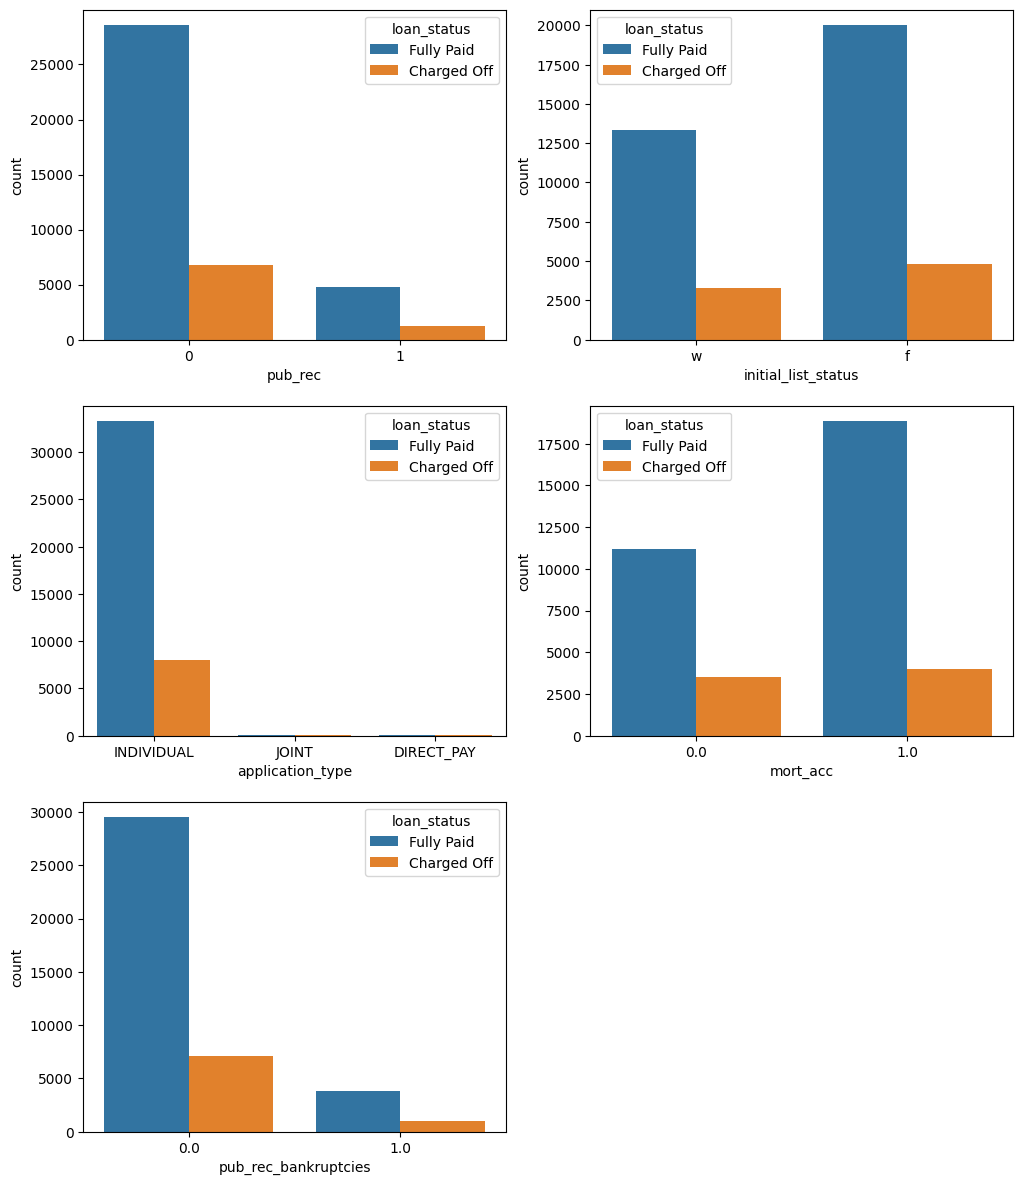

In [651]:
plt.figure(figsize=(12,30))

plt.subplot(6,2,1)
sns.countplot(x='pub_rec',data=data,hue='loan_status')

plt.subplot(6,2,2)
sns.countplot(x='initial_list_status',data=data,hue='loan_status')

plt.subplot(6,2,3)
sns.countplot(x='application_type',data=data,hue='loan_status')

plt.subplot(6,2,4)
sns.countplot(x='mort_acc',data=data,hue='loan_status')

plt.subplot(6,2,5)
sns.countplot(x='pub_rec_bankruptcies',data=data,hue='loan_status')

plt.show()

In [652]:
# Mapping of target variable 
data['loan_status']=data.loan_status.map({'Fully Paid':0, 'Charged Off':1})

In [653]:
data.isnull().sum()/len(data)*100

loan_amnt               0.000000
term                    0.000000
int_rate                0.000000
grade                   0.000000
sub_grade               0.000000
emp_title               5.715115
emp_length              4.593366
home_ownership          0.000000
annual_inc              0.000000
verification_status     0.000000
issue_d                 0.000000
loan_status             0.000000
purpose                 0.000000
title                   0.401315
dti                     0.000000
earliest_cr_line        0.000000
open_acc                0.000000
pub_rec                 0.000000
revol_bal               0.000000
revol_util              0.065274
total_acc               0.000000
initial_list_status     0.000000
application_type        0.000000
mort_acc                9.247171
pub_rec_bankruptcies    0.130548
address                 0.002418
dtype: float64

### Mean Target Imputation

In [654]:
data.groupby(by='total_acc').mean()

,loan_amnt,int_rate,annual_inc,loan_status,dti,open_acc,pub_rec,revol_bal,revol_util,mort_acc,pub_rec_bankruptcies
total_acc,,,,,,,,,,,
2.0,2958.333333,16.340000,102666.666667,0.000000,1.046667,1.333333,0.000000,3124.000000,62.566667,0.000000,0.000000
3.0,7752.142857,15.819714,49651.565714,0.228571,5.381429,2.685714,0.028571,3755.571429,46.780000,0.050000,0.000000
4.0,7792.886179,14.706829,40356.769350,0.170732,8.229187,3.317073,0.040650,5001.593496,58.399180,0.094118,0.032787
5.0,8432.710280,15.335421,45530.233271,0.224299,10.141402,3.859813,0.060748,6152.434579,58.481776,0.078313,0.046948
6.0,8650.338983,14.678881,48725.838780,0.176271,12.434881,4.559322,0.071186,6398.274576,58.912881,0.100000,0.051370
7.0,9393.720096,14.409354,52807.772727,0.212919,12.070048,5.222488,0.093301,7132.052632,58.237321,0.178886,0.062500
8.0,9694.220183,14.247596,52876.310477,0.214679,12.366055,5.508257,0.091743,7974.974312,56.347706,0.229213,0.055762
9.0,9847.713864,14.307655,51765.005147,0.213864,13.263584,6.067847,0.132743,8402.412979,58.043575,0.234375,0.093333
10.0,10453.846154,14.217562,52966.227627,0.211213,13.727562,6.544980,0.119948,8775.010430,56.960966,0.236111,0.084746


In [655]:
total_acc_avg=data.groupby(by='total_acc').mean().mort_acc
# saving mean of mort_acc according to total_acc_avg

In [656]:
def fill_mort_acc(total_acc,mort_acc):
    if np.isnan(mort_acc):
        return total_acc_avg[total_acc].round()
    else:
        return mort_acc

In [657]:
data['mort_acc']=data.apply(lambda x: fill_mort_acc(x['total_acc'],x['mort_acc']),axis=1)

In [658]:
data.isnull().sum()/len(data)*100

loan_amnt               0.000000
term                    0.000000
int_rate                0.000000
grade                   0.000000
sub_grade               0.000000
emp_title               5.715115
emp_length              4.593366
home_ownership          0.000000
annual_inc              0.000000
verification_status     0.000000
issue_d                 0.000000
loan_status             0.000000
purpose                 0.000000
title                   0.401315
dti                     0.000000
earliest_cr_line        0.000000
open_acc                0.000000
pub_rec                 0.000000
revol_bal               0.000000
revol_util              0.065274
total_acc               0.000000
initial_list_status     0.000000
application_type        0.000000
mort_acc                0.000000
pub_rec_bankruptcies    0.130548
address                 0.002418
dtype: float64

In [583]:
# Current no. of rows
data.shape

(41364, 26)

In [584]:
# Dropping rows with null values
data.dropna(inplace=True)


In [585]:
# Remaining no. of rows
data.shape

(38765, 26)

### Outlier Detection and Treatment

In [586]:
numerical_data=data.select_dtypes(include='number')
num_cols=numerical_data.columns
len(num_cols)

12

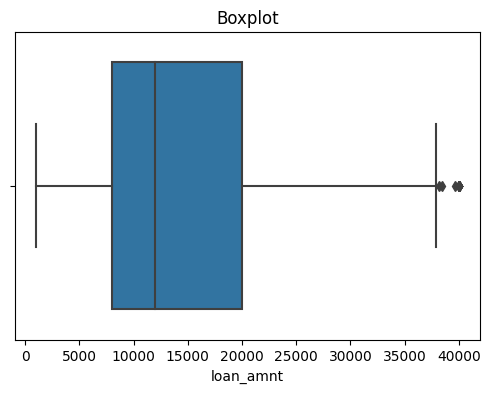

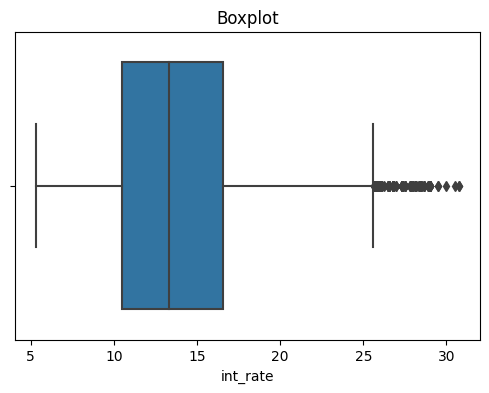

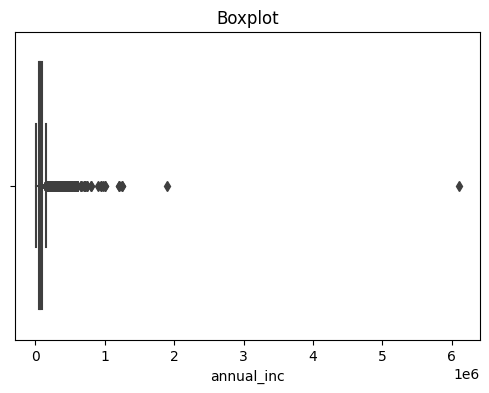

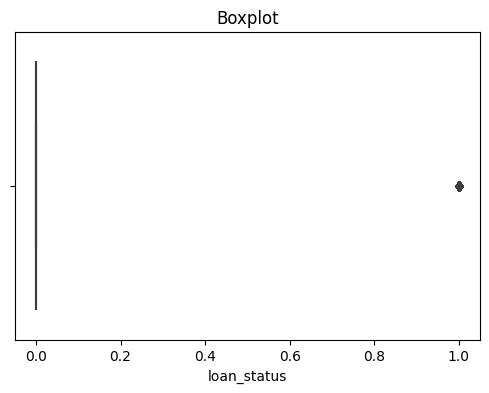

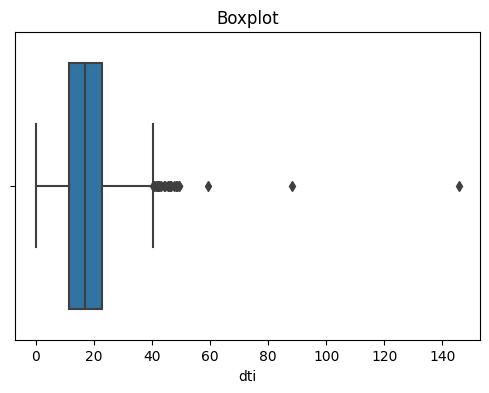

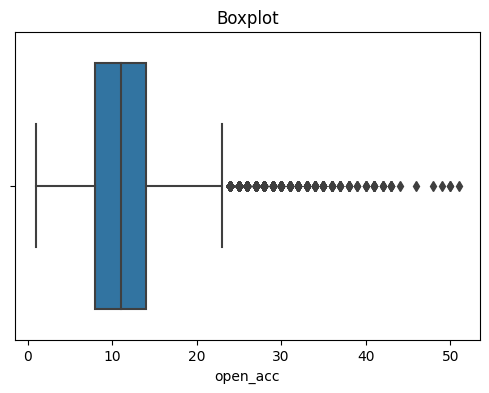

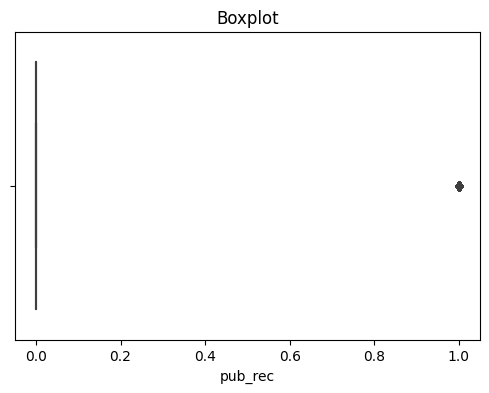

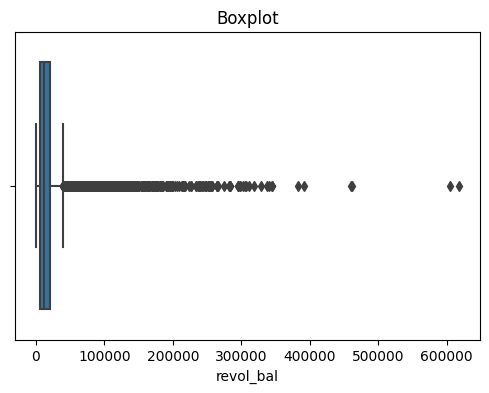

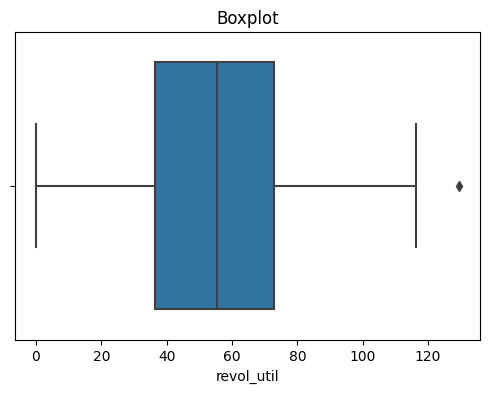

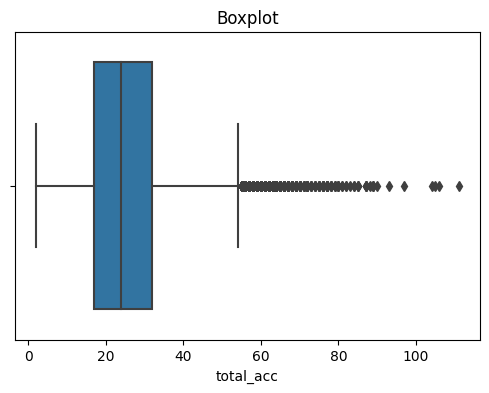

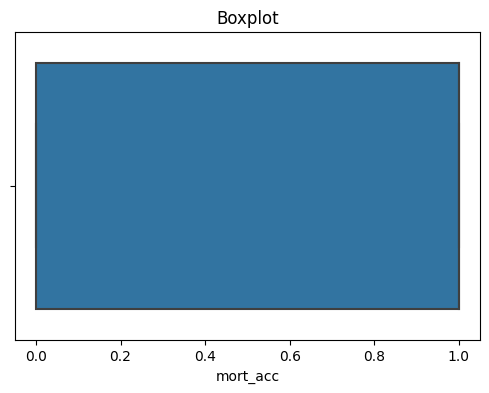

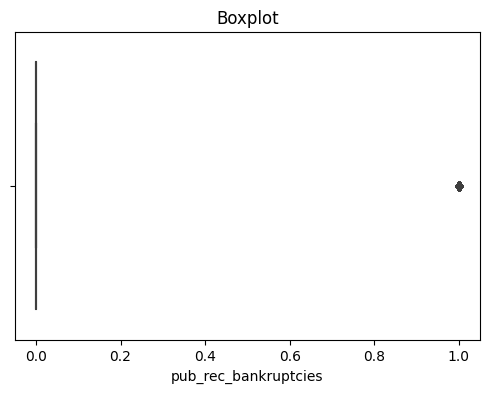

In [587]:
def box_plot(col):
    plt.figure(figsize=(6,4))
    sns.boxplot(x=data[col])
    plt.title('Boxplot')
    plt.show()
    
for col in num_cols:
    box_plot(col)

In [588]:
for col in num_cols:
    mean=data[col].mean()
    std=data[col].std()
    
    upper_limit=mean+3*std
    lower_limit=mean-3*std
    
    data=data[(data[col]<upper_limit) & (data[col]>lower_limit)]
    
data.shape

(37047, 26)

### Data Preprocesing

In [589]:
# Term
data.term.unique()

array([' 36 months', ' 60 months'], dtype=object)

In [590]:
term_values={' 36 months': 36, ' 60 months':60}
data['term'] = data.term.map(term_values)

In [591]:
# Initial List Status
data['initial_list_status'].unique()

array(['w', 'f'], dtype=object)

In [592]:
list_status = {'w': 0, 'f': 1}
data['initial_list_status'] = data.initial_list_status.map(list_status)

In [593]:
# Let's fetch ZIP from address and then drop the remaining details -
data['zip_code'] = data.address.apply(lambda x: x[-5:])

In [594]:
data['zip_code'].value_counts(normalize=True)*100

22690    14.495101
70466    14.495101
30723    14.122601
48052    13.912058
29597    11.660863
00813    11.623073
05113    11.542095
93700     2.791049
86630     2.696575
11650     2.661484
Name: zip_code, dtype: float64

In [595]:
# Dropping some variables which we can let go for now 
data.drop(columns=['issue_d', 'emp_title', 'title', 'sub_grade',
                   'address', 'earliest_cr_line', 'emp_length'], 
                   axis=1, inplace=True)

### One-hot Encoding

In [596]:
dummies=['purpose', 'zip_code', 'grade', 'verification_status', 'application_type', 'home_ownership']
data=pd.get_dummies(data,columns=dummies,drop_first=True)

In [597]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

data.head()

,loan_amnt,term,int_rate,annual_inc,loan_status,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,mort_acc,pub_rec_bankruptcies,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,zip_code_05113,zip_code_11650,zip_code_22690,zip_code_29597,zip_code_30723,zip_code_48052,zip_code_70466,zip_code_86630,zip_code_93700,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,verification_status_Source Verified,verification_status_Verified,application_type_INDIVIDUAL,application_type_JOINT,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
0,10000.0,36,11.44,117000.0,0,26.24,16.0,0,36369.0,41.8,25.0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
1,8000.0,36,11.99,65000.0,0,22.05,17.0,0,20131.0,53.3,27.0,1,1.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0
2,15600.0,36,10.49,43057.0,0,12.79,13.0,0,11987.0,92.2,26.0,1,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1
3,7200.0,36,6.49,54000.0,0,2.60,6.0,0,5472.0,21.5,13.0,1,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
4,24375.0,60,17.27,55000.0,1,33.95,13.0,0,24584.0,69.8,43.0,1,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0,0,0


In [598]:
data.shape

(37047, 50)

### Data Preparation for Modelling¶

In [599]:
X=data.drop('loan_status',axis=1)
y=data['loan_status']

In [600]:
X_train, X_test, y_train, y_test =train_test_split(X,y,test_size=0.30,stratify=y,random_state=42)

In [601]:
print(X_train.shape)
print(X_test.shape)

(25932, 49)
(11115, 49)


### MinMaxScaler -
For each value in a feature, **MinMaxScaler** subtracts the minimum value in the feature and then divides by the range. The range is the difference between the original maximum and original minimum.

**MinMaxScaler** preserves the shape of the original distribution. It doesn’t meaningfully change the information embedded in the original data.

In [602]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Logistic Regression

In [603]:
logreg=LogisticRegression(max_iter=1000)
logreg.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

In [604]:
y_pred = logreg.predict(X_test)
print('Accuracy of Logistic Regression Classifier on test set: {:.3f}'.format(logreg.score(X_test, y_test)))

Accuracy of Logistic Regression Classifier on test set: 0.891


### Confusion Matrix

In [605]:
confusion_matrix=confusion_matrix(y_test,y_pred)
print(confusion_matrix)

[[8946   42]
 [1164  963]]


### Classification Report

In [606]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94      8988
           1       0.96      0.45      0.61      2127

    accuracy                           0.89     11115
   macro avg       0.92      0.72      0.78     11115
weighted avg       0.90      0.89      0.88     11115



### ROC Curve -
An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters:

* True Positive Rate
* False Positive Rate

True Positive Rate (TPR) is a synonym for recall and is therefore defined as follows:

* TPR=(TP)/(TP+FN)
False Positive Rate (FPR) is defined as follows:

* FPR=(FP)/(FP+TN)

An ROC curve plots TPR vs. FPR at different classification thresholds. Lowering the classification threshold classifies more items as positive, thus increasing both False Positives and True Positives. 

### AUC (Area under the ROC Curve) -
AUC stands for "Area under the ROC Curve." That is, AUC measures the entire two-dimensional area underneath the entire ROC curve (think integral calculus) from (0,0) to (1,1).

AUC provides an aggregate measure of performance across all possible classification thresholds. One way of interpreting AUC is as the probability that the model ranks a random positive example more highly than a random negative example. For example, given the following examples, which are arranged from left to right in ascending order of logistic regression predictions.

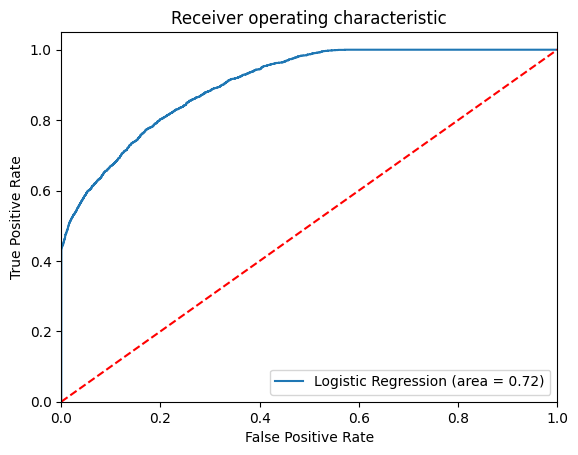

In [607]:
logit_roc_auc=roc_auc_score(y_test,logreg.predict(X_test))
fpr,tpr,thresholds=roc_curve(y_test,logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr,tpr,label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

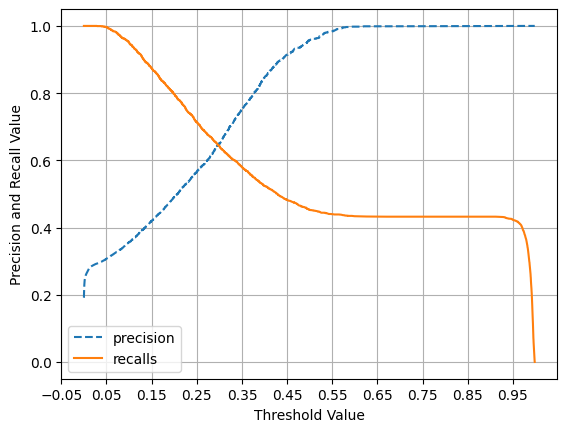

In [608]:
def precission_recall_curve_plot(y_test,pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test,pred_proba_c1)
    
    threshold_boundary = thresholds.shape[0]
    #plot precision
    plt.plot(thresholds,precisions[0:threshold_boundary],linestyle='--',label='precision')
    #plot recall
    plt.plot(thresholds,recalls[0:threshold_boundary],label='recalls')
    
    start,end=plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    
    plt.xlabel('Threshold Value')
    plt.ylabel('Precision and Recall Value')
    plt.legend()
    plt.grid()
    plt.show()

precission_recall_curve_plot(y_test,logreg.predict_proba(X_test)[:,1])

### Multicollinearity check using Variance Inflation Factor (VIF) -
Multicollinearity occurs when two or more independent variables are highly correlated with one another in a regression model. Multicollinearity can be a problem in a regression model because we would not be able to distinguish between the individual effects of the independent variables on the dependent variable.

Multicollinearity can be detected via various methods. One such method is Variance Inflation Factor aka VIF. In VIF method, we pick each independent feature and regress it against all of the other independent features. VIF score of an independent variable represents how well the variable is explained by other independent variables.

In [609]:
def calc_vif(X):
    # Calculating the VIF
    vif=pd.DataFrame()
    vif['Feature']=X.columns
    vif['VIF']=[variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
    vif['VIF']=round(vif['VIF'],2)
    vif=vif.sort_values(by='VIF',ascending=False)
    return vif

calc_vif(X)[:5]

,Feature,VIF
43,application_type_INDIVIDUAL,3714.90
45,home_ownership_MORTGAGE,1901.55
48,home_ownership_RENT,1603.08
47,home_ownership_OWN,341.55
2,int_rate,122.81


In [610]:
X.drop(columns=['application_type_INDIVIDUAL'],axis=1,inplace=True)
calc_vif(X)[:5]

,Feature,VIF
2,int_rate,122.81
44,home_ownership_MORTGAGE,78.27
47,home_ownership_RENT,63.15
14,purpose_debt_consolidation,49.51
1,term,27.51


In [611]:
X.drop(columns=['int_rate'], axis=1, inplace=True)
calc_vif(X)[:5]

,Feature,VIF
43,home_ownership_MORTGAGE,65.45
46,home_ownership_RENT,52.55
13,purpose_debt_consolidation,49.49
1,term,27.47
12,purpose_credit_card,18.19


In [612]:
X.drop(columns=['home_ownership_MORTGAGE'], axis=1, inplace=True)
calc_vif(X)[:5]


,Feature,VIF
1,term,23.35
13,purpose_debt_consolidation,22.11
4,open_acc,13.46
8,total_acc,12.70
7,revol_util,9.12


In [613]:
X.drop(columns=['term'], axis=1, inplace=True)
calc_vif(X)[:5]


,Feature,VIF
12,purpose_debt_consolidation,18.36
3,open_acc,13.46
7,total_acc,12.67
6,revol_util,9.11
1,annual_inc,8.13


In [614]:
X.drop(columns=['purpose_debt_consolidation'], axis=1, inplace=True)
calc_vif(X)[:5]


,Feature,VIF
3,open_acc,12.95
7,total_acc,12.65
6,revol_util,8.40
1,annual_inc,7.78
2,dti,7.61


In [615]:
X.drop(columns=['open_acc'], axis=1, inplace=True)
calc_vif(X)[:5]


,Feature,VIF
6,total_acc,8.35
5,revol_util,8.09
1,annual_inc,7.68
2,dti,7.03
0,loan_amnt,6.70


In [616]:
X=scaler.fit_transform(X)

kfold=KFold(n_splits=5)
accuracy=np.mean(cross_val_score(logreg,X,y,cv=kfold,scoring='accuracy',n_jobs=-1))
print("Cross Validation accuracy : {:.3f}".format(accuracy))

Cross Validation accuracy : 0.891


### Oversampling using SMOTE

In [617]:
sm=SMOTE(random_state=42)
X_train_res,y_train_res=sm.fit_resample(X_train,y_train.ravel())

In [618]:
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

After OverSampling, the shape of train_X: (41942, 49)
After OverSampling, the shape of train_y: (41942,) 

After OverSampling, counts of label '1': 20971
After OverSampling, counts of label '0': 20971


In [619]:
lr1 = LogisticRegression(max_iter=1000)
lr1.fit(X_train_res, y_train_res)
predictions = lr1.predict(X_test)
  
# Classification Report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.94      0.79      0.86      8988
           1       0.47      0.80      0.59      2127

    accuracy                           0.79     11115
   macro avg       0.71      0.79      0.73     11115
weighted avg       0.85      0.79      0.81     11115



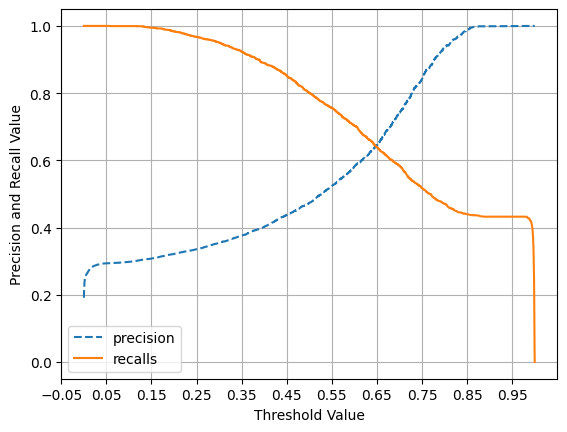

In [527]:
def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    threshold_boundary = thresholds.shape[0]
    # plot precision
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    # plot recall
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recalls')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    plt.xlabel('Threshold Value'); plt.ylabel('Precision and Recall Value')
    plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, lr1.predict_proba(X_test)[:,1])

### Actionable Insights and Recommendations:
1. We can see that around 80% of the customers have fully paid the loan amount.
2. ROC-AUC : Not good metric to consider as we have highly imbalanced data.
3. Precision: Consider when only want to reduce NPA
4. Recall: Consider when we do not want to miss good opportunity for providing loan to customer
5. F1-score: Good metric for us, because we want to consider both Precision and Recall.
6. Grade B customers are more likely to pay the full amount of loan.
6. Below are few important features for us:

* Loan sub-grade
* Annual Income
* Interest rate
* Mortgaged accounts
* Purpose
* Application Type
* Employment Length
* Home Ownership
* term : number of payments on the loan
* debt to income ratio